In [1]:
from skimage.io import imread
import pyclesperanto_prototype as cle
import matplotlib.pyplot as plt
from cellpose import models, io
from csbdeep.utils import normalize
from napari_simpleitk_image_processing import label_statistics
from napari_segment_blobs_and_things_with_membranes import seeded_watershed
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
import numpy as np


In [2]:
def show_crop(image, labels=False, color_map=None):
    """Helper function for visualizing the whole image next to a crop"""
    cropped_image = cle.pull(image)[800:1400, 500:1100]

    fix, axs = plt.subplots(1, 2, figsize=(15,15))

    cle.imshow(image, plot=axs[0], labels=labels, color_map=color_map)
    cle.imshow(cropped_image, plot=axs[1], labels=labels, color_map=color_map)
    
    

Esteban et al shared under CC-BY 4.0 
https://creativecommons.org/licenses/by/4.0/

Data Link/DOI:
https://doi.org/10.17867/10000174



In [3]:
multi_channel_image = imread("../../data/E39.lif [E4] - 2.png")
multi_channel_image.shape

(1616, 1682, 4)

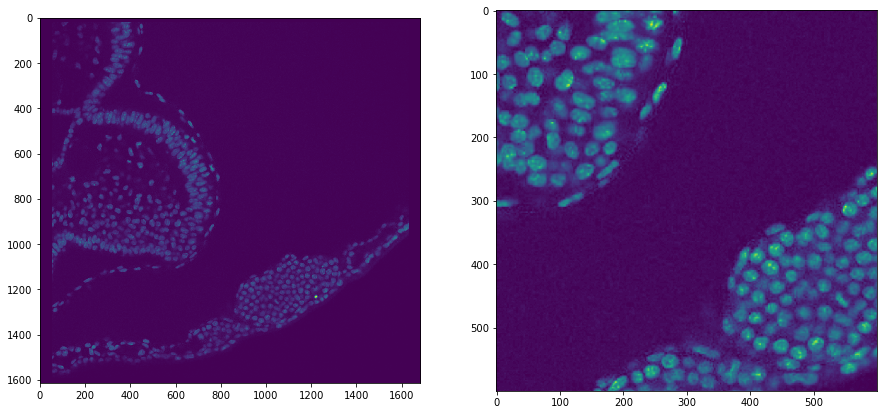

In [4]:
nuclei_channel_image = multi_channel_image[:,:,2]

show_crop(nuclei_channel_image)

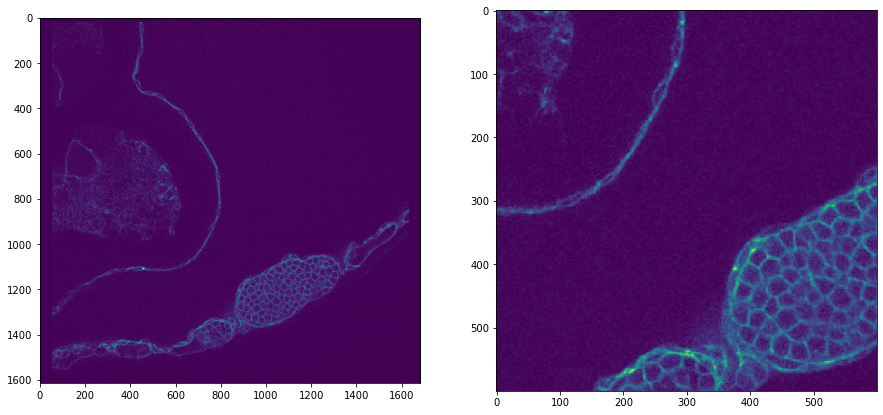

In [5]:
membrane_channel_image = multi_channel_image[:,:,1]

show_crop(membrane_channel_image)

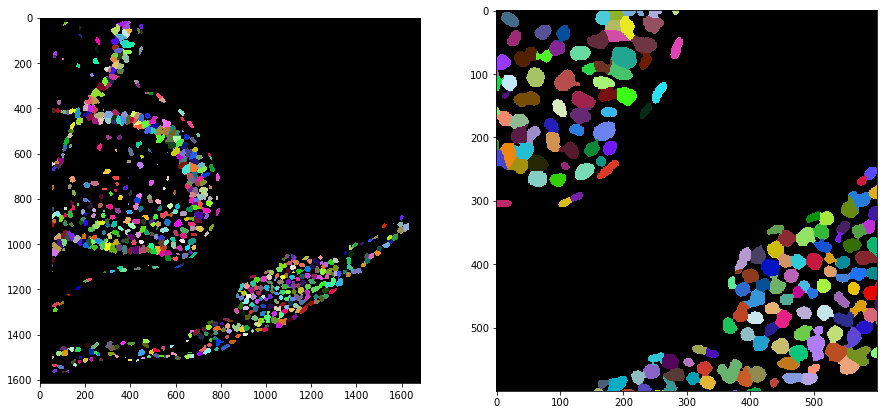

In [6]:
nuclei_labels = cle.voronoi_otsu_labeling(nuclei_channel_image, spot_sigma=4)

show_crop(nuclei_labels, labels=True)

In [7]:
print("Number of nuclei", nuclei_labels.max())

Number of nuclei 615.0


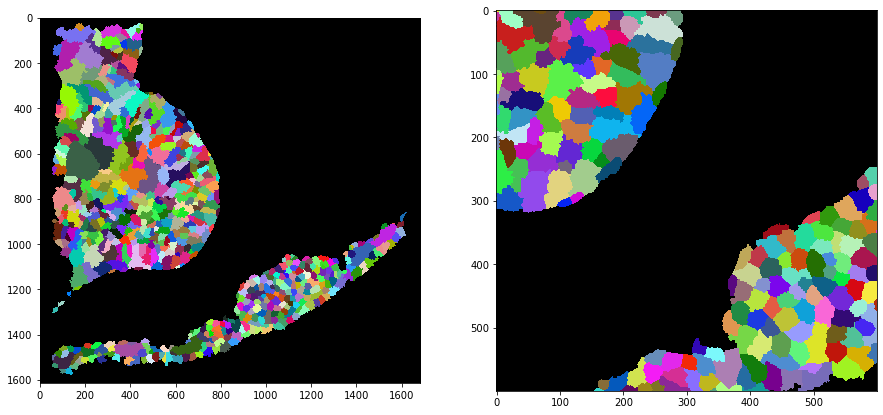

In [8]:
cell_labels = cle.exclude_labels_on_edges(
    seeded_watershed(membrane_channel_image, nuclei_labels)
)
show_crop(cell_labels, labels=True)

In [9]:
print("Number of nuclei", cell_labels.max())

Number of nuclei 597.0


In [10]:
statistics = label_statistics(membrane_channel_image, cell_labels,
                             intensity=True,
                             perimeter=True,
                             shape=True)

statistics.keys()

dict_keys(['label', 'maximum', 'mean', 'median', 'minimum', 'sigma', 'sum', 'variance', 'elongation', 'feret_diameter', 'flatness', 'roundness', 'equivalent_ellipsoid_diameter_0', 'equivalent_ellipsoid_diameter_1', 'equivalent_spherical_perimeter', 'equivalent_spherical_radius', 'number_of_pixels', 'number_of_pixels_on_border', 'perimeter', 'perimeter_on_border', 'perimeter_on_border_ratio'])

In [11]:
table = pd.DataFrame(statistics)[['mean', 'sigma', 'elongation', 'feret_diameter', 'flatness','roundness', 'number_of_pixels']]
table

,mean,sigma,elongation,feret_diameter,flatness,roundness,number_of_pixels
0,10.296167,5.327664,2.081825,28.792360,2.081825,0.773051,287
1,2.780115,1.414019,1.969280,36.496575,1.969280,0.797266,523
2,6.276657,3.751470,1.279357,26.172505,1.279357,0.834182,347
3,6.228637,3.183568,1.422571,28.600699,1.422571,0.896697,433
4,8.095427,4.355566,1.490810,34.655447,1.490810,0.888096,503
...,...,...,...,...,...,...,...
592,19.897959,3.150694,2.834289,14.035669,2.834289,0.724192,49
593,2.899651,4.661415,1.125834,47.381431,1.125834,0.794405,1146
594,14.477372,5.571820,1.650344,42.426407,1.650344,0.814952,685
595,13.119929,5.436080,2.628860,46.647615,2.628860,0.737590,567


## Studying spatial distribution of measurements

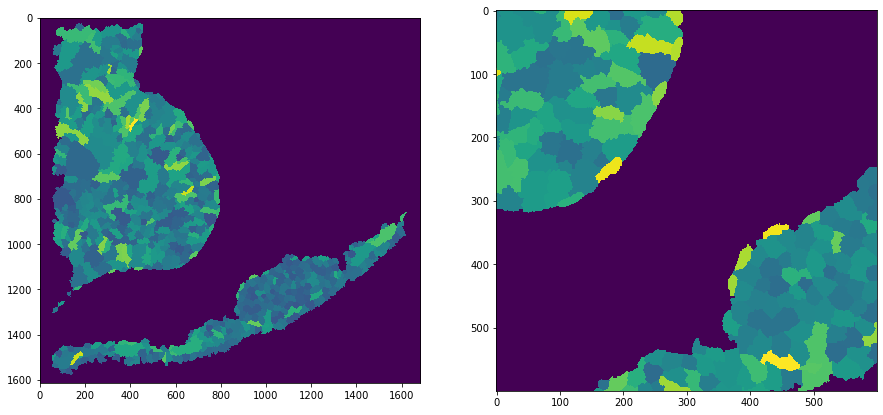

In [12]:
# the [0] is a placeholder for the elongation of the background
elongation_vector = [0] + table['elongation'].tolist()

elongation_map = cle.replace_intensities(cell_labels, elongation_vector)

show_crop(elongation_map)

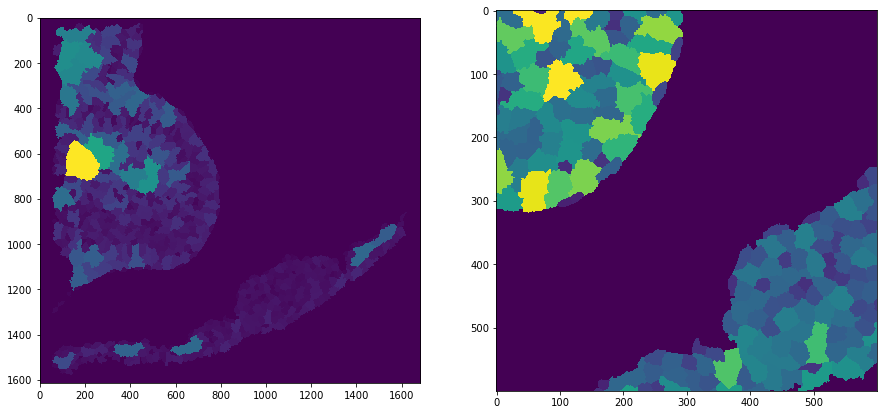

In [13]:
area_map = cle.pixel_count_map(cell_labels)
show_crop(area_map)

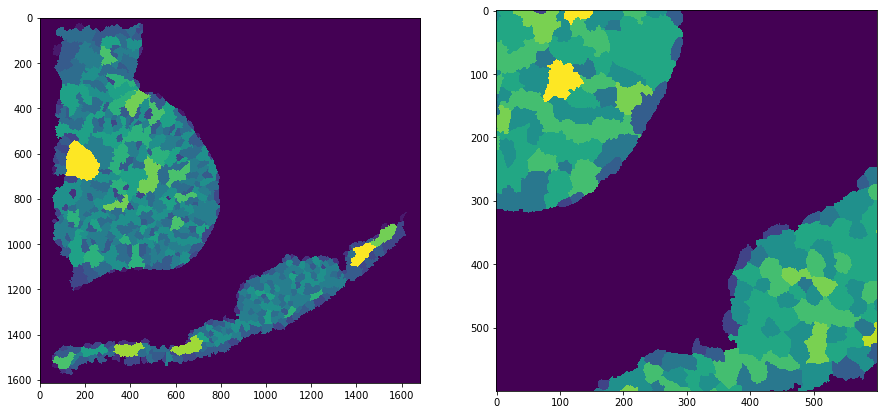

In [14]:
touching_neighbor_count_map = cle.touching_neighbor_count_map(cell_labels)
show_crop(touching_neighbor_count_map)

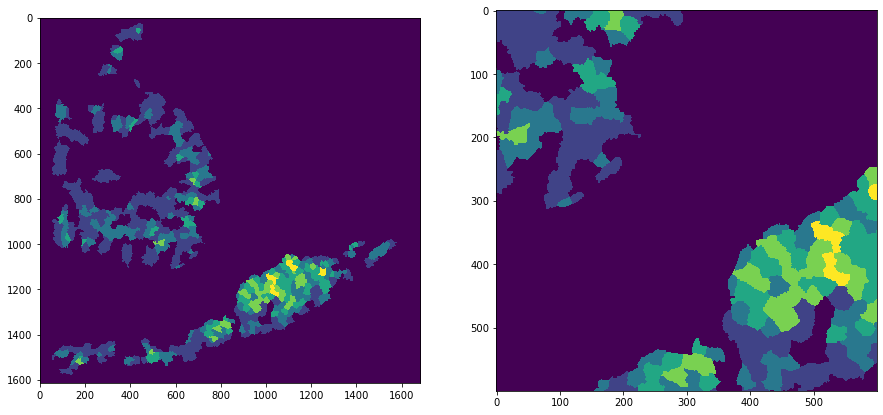

In [15]:
proximal_neighbor_count_map = cle.proximal_neighbor_count_map(cell_labels, max_distance=30)
show_crop(proximal_neighbor_count_map)

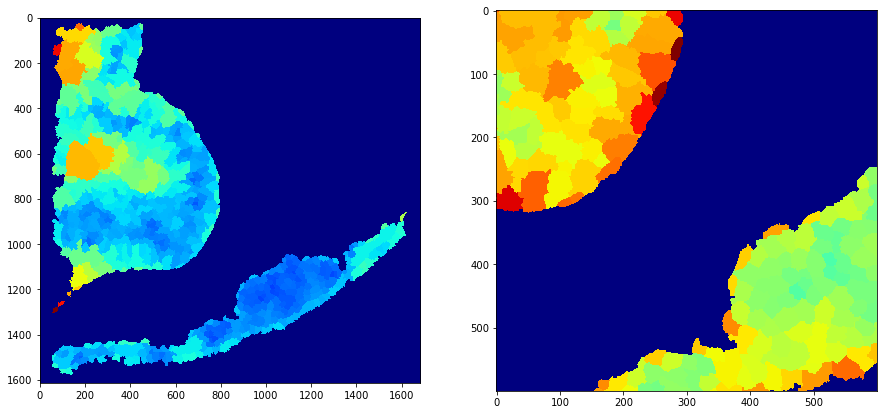

In [16]:
neighbor_distance_map = cle.average_distance_of_n_nearest_neighbors_map(cell_labels, n=6)

show_crop(neighbor_distance_map, color_map="jet")

In [17]:
number_of_touching_neighbors = cle.read_intensities_from_map(cell_labels, touching_neighbor_count_map)
number_of_proximal_neighbors = cle.read_intensities_from_map(cell_labels, proximal_neighbor_count_map)
neighbor_distances = cle.read_intensities_from_map(cell_labels, neighbor_distance_map)

# Remove place holder for background
proximal_neighbor_count_vector = np.asarray(number_of_proximal_neighbors)[0,1:].tolist()
touching_neighbor_count_vector = np.asarray(number_of_touching_neighbors)[0,1:].tolist()
neighbor_distance_count_vector = np.asarray(neighbor_distances)[0,1:].tolist()

table['proximal_neighbor_count_vector'] = proximal_neighbor_count_vector
table['touching_neighbor_count_vector'] = touching_neighbor_count_vector
table['neighbor_distance_count_vector'] = neighbor_distance_count_vector

len(proximal_neighbor_count_vector)

597

## Studying relationships between parameters

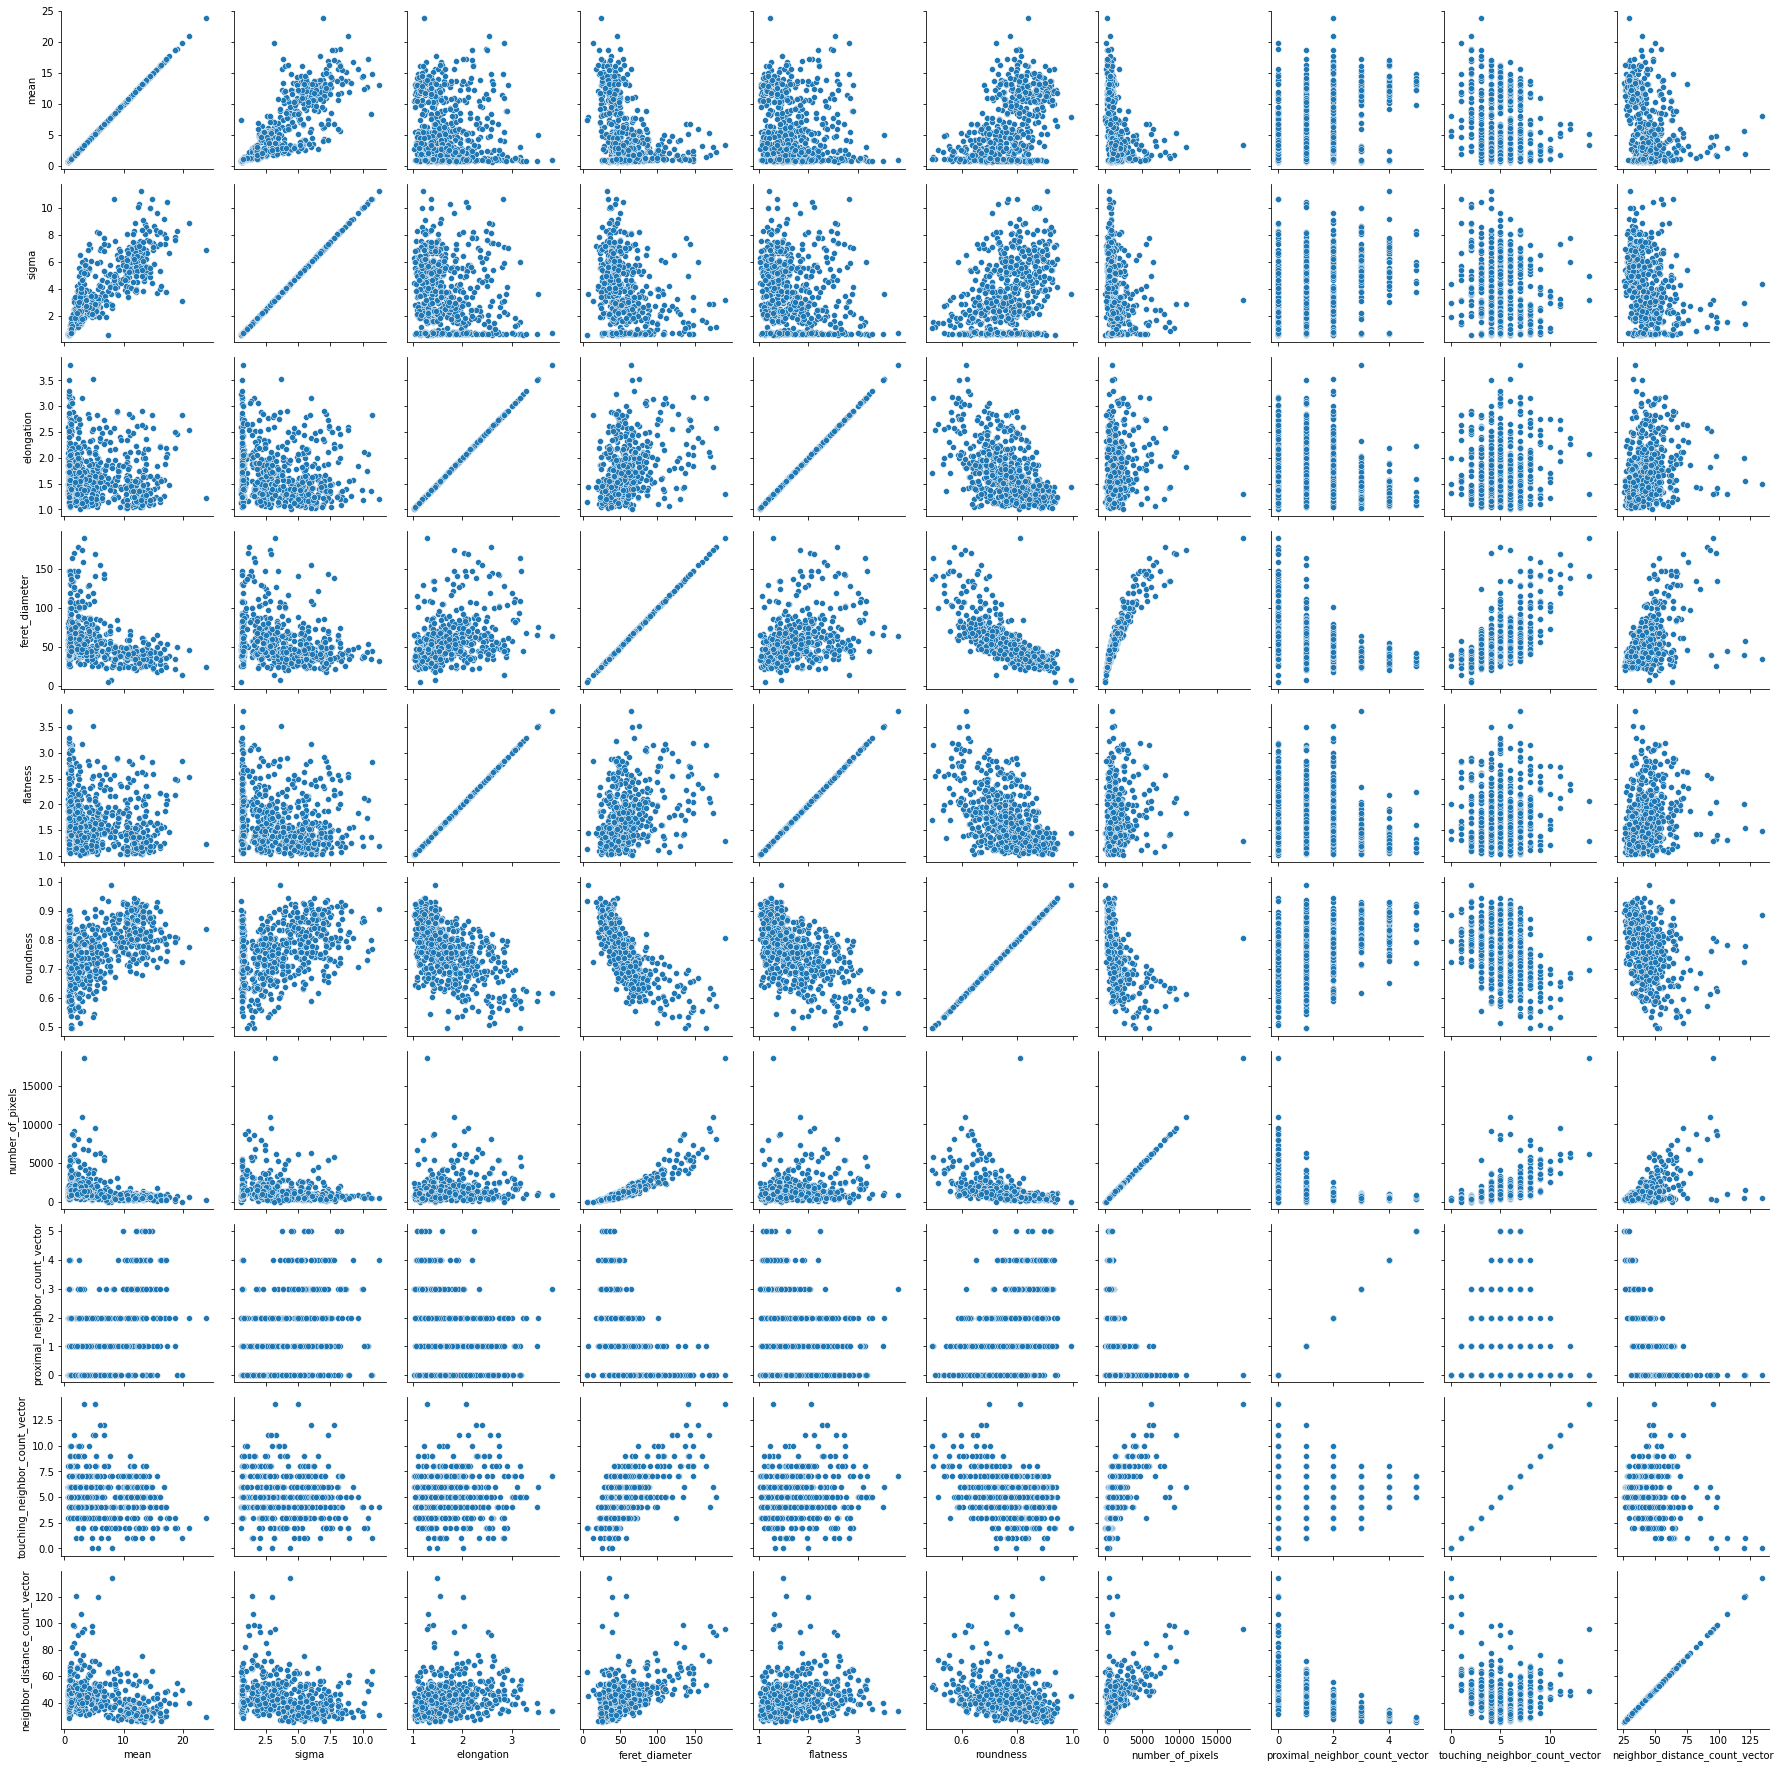

In [18]:
g = sns.PairGrid(table)
g.map(sns.scatterplot)

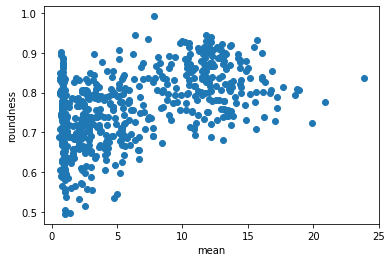

In [19]:
roundness = table['roundness']
mean = table['mean']

plt.scatter(mean, roundness)
plt.xlabel("mean")
plt.ylabel("roundness")
plt.show()

## Manual clustering using thresholds

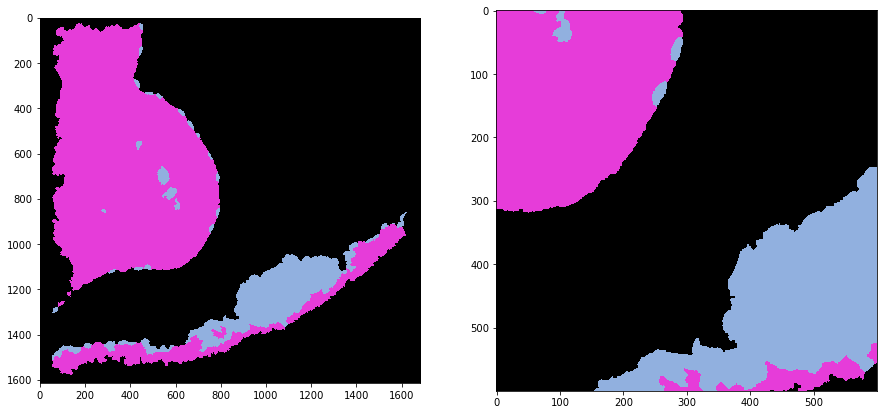

In [20]:
mean_high_vector = (mean > 8) * 1 + 1

mean_high_map = cle.replace_intensities(cell_labels, np.asarray([0] + mean_high_vector.tolist()))
#show_crop(mean_high_map)

# cle.imshow(mean_high_map, color_map='jet', min_display_intensity=0, max_display_intensity=3)
show_crop(mean_high_map, labels=True)

In [21]:
np.min(mean_high_map)

0.0

In [22]:
np.max(mean_high_map)

2.0

## Scaling

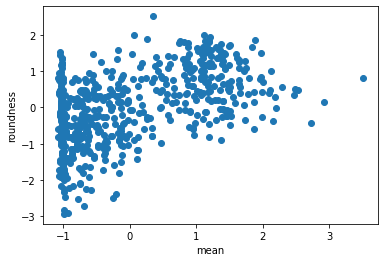

In [23]:
data = np.asarray([
    table['mean'],
    table['roundness'],
]).T

scaler = StandardScaler()
scaler.fit(data)
normalized_data = scaler.transform(data)

plt.scatter(normalized_data[:,0], normalized_data[:,1])
plt.xlabel("mean")
plt.ylabel("roundness")
plt.show()

## Gaussian mixture model

In [24]:
num_classes = 2
color_iter = ['navy', 'red', 'darkgreen', 'gold', 'darkorange']

In [25]:
# fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=num_classes, covariance_type='full')
gmm.fit(normalized_data)

# prediction
gmm_prediction = gmm.predict(normalized_data)

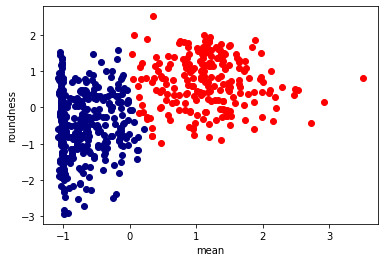

In [26]:
for i in range(num_classes):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(normalized_data[gmm_prediction == i, 0], normalized_data[gmm_prediction == i, 1], color=color)

plt.xlabel("mean")
plt.ylabel("roundness")
plt.show()

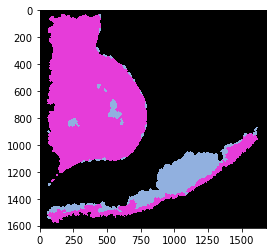

In [27]:
gmm_prediction_map = cle.replace_intensities(cell_labels, np.asarray([0] + (gmm_prediction + 1).tolist()))

cle.imshow(gmm_prediction_map, labels=True)

## K-means clustering

In [28]:
kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(normalized_data)

kmeans_prediction = kmeans.predict(normalized_data)

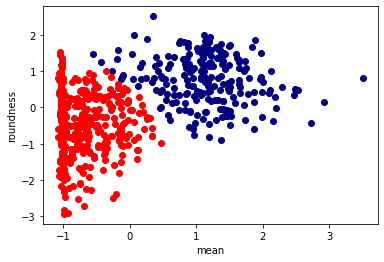

In [29]:
for i in range(num_classes):
    #splot = plt.subplot(2, 1, 1 + index)
    color = color_iter[i]
    plt.scatter(normalized_data[kmeans_prediction == i, 0], normalized_data[kmeans_prediction == i, 1], color=color)

plt.xlabel("mean")
plt.ylabel("roundness")
plt.show()

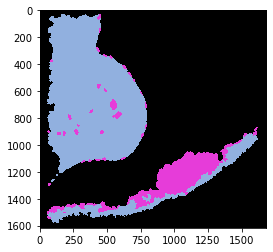

In [30]:
kmeans_prediction_map = cle.replace_intensities(cell_labels, np.asarray([0] + (kmeans_prediction + 1).tolist()))

cle.imshow(kmeans_prediction_map, labels=True)

## Applying clustering to the whole dataset

In [31]:
data = np.asarray([
    # intensity
    table['mean'],
    table['sigma'], 
    
    # shape and size
    table['elongation'], 
    table['feret_diameter'], 
    table['flatness'],
    table['roundness'], 
    table['number_of_pixels'],
    
    # neighborhood statistics
    table['proximal_neighbor_count_vector'],
    table['touching_neighbor_count_vector'],
    table['neighbor_distance_count_vector'],
]).T

In [32]:
scaler = StandardScaler()
scaler.fit(data)
normalized_data = scaler.transform(data)

In [33]:
num_classes = 5

In [34]:
kmeans = KMeans(n_clusters=num_classes, random_state=0).fit(normalized_data)

kmeans_prediction = kmeans.predict(normalized_data)

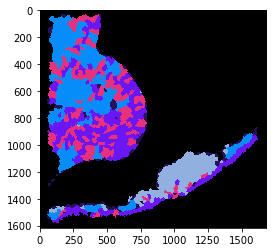

In [35]:
kmeans_prediction_map = cle.replace_intensities(cell_labels, np.asarray([0] + (kmeans_prediction + 1).tolist()))

cle.imshow(kmeans_prediction_map, labels=True)

## Exercise
Apply a Gaussian mixture models with 4 classes to the full dataset and visualzie the cell classification result